# TL;DR

This notebook:
* take a row index of the Poland 10km square shapefile as AOI to download a unique satellite tile for the gowing season of 2018 from 2018-05-01 (start_date) to 2018-10-31 (stop_date).
* Create an RGB image from one image of one date and run the "segment-anything" on it to get a "masks" list of all segments.
* Clean the masks to remove almost duplicates and too large areas
* Save the mask as a unique boolean mask without any overlapp in a shapefile which can be used for labelling.


## Run me

* In cell "Input needed: select an AOI" set variable "rowid" as any of the suggested Index for the Aoi. 
* Run Part 0 Installation and Initialization
* Restart Runtime
* Run all or you can also run cell by cell.

WARNING: it will take a while so be partient.

## WARNINGS

Files which will be overwritten:
* global_config.py
* masks.npy
* rgb_da_numpy_converted.png

Save your file first before run this notebook if you would like to keep them.

Hard coded:

Be aware that for now the location of the config file is hard coded:
'/content/drive/MyDrive/omdena-poland/task-1-dataset/global_config.py'

It can be improved later.


## Input needed: select an AOI

In [1]:
# select an AOI from a row index of the Poland 10km square shapefile
# Opole - Index [1609]
# Holy Cross - Index [3169, 3109]
# demo original [177]

rowid = 1609

## Ouput: Shapefile of unique segmented polygons without overlapps

Output saved to: shp_dir/***tileId***_code_demo_clustering_x***coordinates***_y***coordinates***_step***chunksize***.shp

# Part 0: Installation and Initialization

### Mount Google Drive

Where data is stored and loaded.

In [2]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Import packages

First, check the contents of the current working directory to make sure the python files with the functions and global parameters are accessible. Then, load import the fields_functions.py file. The config parameters are stored in the global_config.py, imported at the top of the fields_functions.py along with all the packages necessary for processing. 

In [3]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [4]:
!conda --version

conda 23.3.1


In [5]:
!conda install gdal=3.6.3

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/linux-64::mamba==1.4.1=py310h51d5547_0
  - conda-forge/linux-64::libmamba==1.4.1=hcea66bb_0
  - conda-forge/linux-64::libmambapy==1.4.1=py310h1428755_0
\ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: 

In [6]:
# Update pip
!python -m pip install -U pip
# Install scikit-image
!python -m pip install -U scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_image-0.20.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.2 MB)
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3


In [7]:
!pip install -r /content/drive/MyDrive/omdena-poland/task-1-dataset/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_image-0.19.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.9 MB)
  Attempting uninstall: scikit_image
    Found existing installation: scikit-image 0.20.0
    Uninstalling scikit-image-0.20.0:
      Successfully uninstalled scikit-image-0.20.0


In [8]:
import os
from glob import glob
from pprint import pprint
from folium import Marker, Figure
from os import path
%matplotlib inline

cwd = os.getcwd()
print(cwd)

py_files = glob('/content/drive/MyDrive/omdena-poland/task-1-dataset/*.py')
print(py_files)

/content
['/content/drive/MyDrive/omdena-poland/task-1-dataset/fields_functions.py', '/content/drive/MyDrive/omdena-poland/task-1-dataset/global_config.py']


In [9]:
import sys
sys.path.append('/content/drive/MyDrive/omdena-poland/task-1-dataset/')

In [10]:
### Import fields functions
from fields_functions import *

### Packages for some plotting to view outputs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

Previously modified global_config.py loaded.


# Introduction: Field Mapping Code: Clustering Approach Demonstration Notebook

This notebook walks through the different processing steps necessary to load Sentinel-2 data (from raw zipped .SAFE files or from a prepared sample dataset) and analyze the imagery through two workflows: Clustering and Thresholding. The core functions are stored in the fields_functions.py file, which references a file with global parameters, the global_config.py file, that stores parameters in a dictionary. Refer to that file to see what each parameter controls. Changing parameters can be done interactively in this notebook by reassigning new values to the parameter, such as: `config['prep_file_dir'] = 'path/to/directory/with/sentinel/tiles/'` 

Since there are multiple ways to load and process data, this notebook should not be run sequentially in full. The first step is loading the data. This can be done by using the `prep_data()` function to load data from a directory of zipped .SAFE Sentinel-2 L2A tiles. Since these tiles are large (about 1 GB per tile), the data is not directly available with the code. In order to enable testing of the analysis code, we have provided a sample dataset as part of thie repo. To load that, run the cell under the "Load Sample Data" heading.

NOTE: In addition to the text description, most of the code is commented for clarity.

# Part 1: Download satellite tile in the Aoi

A satellite tile is directly downloaded from the Area of interest (Aoi) as defined by a shapefile file of Poland cut in 10km squares. One of those squares need to be defined in advance by the row id of that shapefile to select a Aoi.

## Connect to the Copernicus Hub API

We will not use the Graphical User Interface from the Copernicus Open Access Hub as we want something fully automated, so we will use the API instead.

We will use the SentinelAPI: https://sentinelsat.readthedocs.io/en/latest/api_overview.html

In [11]:
#Enter default username and password

username = 'ludiusvox'
password = 'Gmoney300@'

config["username"] = username
config["password"] = password

api = SentinelAPI(username,password, "https://scihub.copernicus.eu/dhus")

### Changing global parameters

Let's take a look at the config parameters. The prefix for each parameter refers to the step in the processing workflow that corresponds with the parameters. For more detail about what each parameter controls, refer to the global_config.py file.

WARNING: it will not change the variable in the global_config.py file, only in the local "config" dictionnary.
It is needed to save those new paramters in the global_config.py before running any functions and modules in the fields_functions file, otherwise the default variables will be applied. This will be done when all new parameters are updated later in the notebook.

In [12]:
### We can change a parameter in the config dictionary by assigning it directly as so:
## WARNING: it will not change the variable in the global_config.py file, only in the local "config" dictionnary

# current paramters (will be changed automatically accroding to AOI later)
print("current x coordinate pixel start point for the tile subset:",config['prep_x_start']) # default 7500
print("current y coordinate pixel start point for the tile subset:",config['prep_y_start']) # default 7500

## Note: 500 pixels corresponds to 5km (resolution 10m per pixel)
config['prep_base_chunk'] = 500 # default 500
config['prep_manual_subset'] = True # force the subset to de defined manually
config['prep_remove_overlap'] = False # force to not use any overlap shift in the pixel coordinates
config['prep_load_cloud_mask'] = False #disable cloud mask
config['prep_apply_cloud_mask'] = False

# selection of cloud coverage 
# NOTE: with a too low coverage (below 30) several harvest month images maybe be missing
prep_cloud_coverage_thresh = 30
config["prep_cloud_coverage_thresh"] = prep_cloud_coverage_thresh

print(config)

current x coordinate pixel start point for the tile subset: 708406.8671437781
current y coordinate pixel start point for the tile subset: 5558268.745109705
{'prep_file_dir': '/content/drive/MyDrive/omdena-poland/data', 'prep_tile_id': 'UYR', 'prep_base_chunk': 500, 'prep_time_chunk': 'auto', 'prep_remove_overlap': False, 'prep_manual_subset': True, 'prep_x_start': 708406.8671437781, 'prep_y_start': 5558268.745109705, 'prep_step': 500, 'prep_cloud_coverage_thresh': 30, 'prep_load_cloud_mask': False, 'prep_apply_cloud_mask': False, 'prep_cloud_mask_thresh': 70, 'prep_clip_outliers': True, 'prep_clip_percentile': 1, 'prep_normalize_bands': True, 'username': 'ludiusvox', 'password': 'Gmoney300@', 'preproc_out_dir': '/content/drive/MyDrive/omdena-poland/preproc', 'preproc_outfile_prefix': 'fields_preproc_demo_', 'preproc_sample_pct': 0.05, 'preproc_n_clusters': 15, 'preproc_cluster_tile': True, 'kmeans_n_clusters': 15, 'kmeans_model_out_dir': 'kmeans_model_dir/', 'kmeans_8var_clusters': Tru

### Loading data

The prep_data() function expects the `'prep_data_dir'` parameter in the config dictionary to have zipped Sentinel-2 L2A tiles. L2A tiles have been preprocessed to estimate bottom of atmosphere pixel values, correcting for atmospheric aerosols. The metadata for L1C data is apparently structured differently and does not work with the GDAL function to read the tile info.

The sample data comes in four versions for an area in Poland from a tile in the Aoi during the 2018 groing season: 500x500 pixels with and without cloud mask applied.

In our case for Poland, we will use directly zipped Sentinel-2 L2A tiles and the prep_data() module right after.

### Download L2A tiles

Sentinel images (aka data cubes) are called tiles and can be downloaded directly from the Copernicus Hub. The only thing which is needed is a shapefile of Area of Interest (aoi) to find the corresponding tile. In our case, we are interested in the full country of Poland which is our aoi. Luckily a shapefile for Poland can be found here: https://www.eea.europa.eu/data-and-maps/data/eea-reference-grids-2/gis-files/poland-shapefile

For our purpose, we will use the shapefile where the Poland area is devided in 10km squares area as illustrated below:

![pl_10km](pl_10km.png)

It is not perfect and we may need to remove squares which are 100% sea and which do not belong to Poland but the neigbhour countries.

In this demo, we will work only with one random selected square from this grid. As we do not know which squares are land or sea, we will first visualize the random selected square first. If it is land, we will use a seed to fix it for the demo, if it is sea we run the random selection again until we find land.

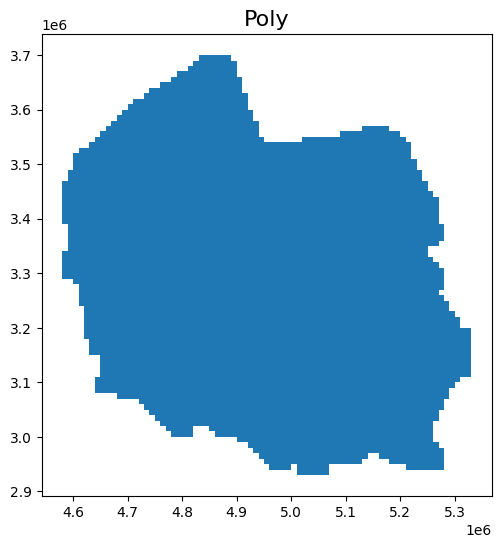

In [13]:
# Plot the shapefile
poly = gpd.read_file("/content/drive/MyDrive/omdena-poland/task-1-dataset/pl_10km.shp") # previously "POLYGON.shp"
fig, ax = plt.subplots(figsize=(6, 6))

poly.plot(ax=ax)

ax.set_title("Poly",fontsize=16)
plt.show()

In [14]:
# Load shape file
shapefile_all = gpd.read_file("/content/drive/MyDrive/omdena-poland/task-1-dataset/pl_10km.shp")
# Explore:
print(shapefile_all.head())
print(shapefile_all.crs)

       CELLCODE  EOFORIGIN  NOFORIGIN  \
0  10kmE458N329    4580000    3290000   
1  10kmE458N330    4580000    3300000   
2  10kmE458N331    4580000    3310000   
3  10kmE458N332    4580000    3320000   
4  10kmE458N333    4580000    3330000   

                                            geometry  
0  POLYGON ((4580000.000 3290000.000, 4580000.000...  
1  POLYGON ((4580000.000 3300000.000, 4580000.000...  
2  POLYGON ((4580000.000 3310000.000, 4580000.000...  
3  POLYGON ((4580000.000 3320000.000, 4580000.000...  
4  POLYGON ((4580000.000 3330000.000, 4580000.000...  
epsg:3035


The coordinate system is epsg:3035 and will need to be converted it to epsg:4326 for the SentinelAPI call. We also need to convert the shapefile to GeoJSON.

In [15]:
# change CRS to epsg 4326 - for API call and visualization with folium
shapefile_all_transformed = shapefile_all.to_crs(epsg=4326) #Geometry is in a geographic CRS
print(shapefile_all_transformed.head())
print(shapefile_all_transformed.crs)

       CELLCODE  EOFORIGIN  NOFORIGIN  \
0  10kmE458N329    4580000    3290000   
1  10kmE458N330    4580000    3300000   
2  10kmE458N331    4580000    3310000   
3  10kmE458N332    4580000    3320000   
4  10kmE458N333    4580000    3330000   

                                            geometry  
0  POLYGON ((13.82950 52.65766, 13.83735 52.74738...  
1  POLYGON ((13.83735 52.74738, 13.84523 52.83710...  
2  POLYGON ((13.84523 52.83710, 13.85316 52.92682...  
3  POLYGON ((13.85316 52.92682, 13.86112 53.01653...  
4  POLYGON ((13.86112 53.01653, 13.86913 53.10625...  
EPSG:4326


In [16]:
# transform the polygons coordinates to the coordinate system of the satellite tile image
shapefile_all_transformed_tile = shapefile_all.to_crs(epsg=32633)

## Select one polygon from the aoi.ipynb notebook

In [17]:
# select a random square for demo (I ran it twice and found a land square aoi so I fixed the seed for the demo)
# Opole - Index [1609]
# Holy Cross - Index [3169, 3109]
# demo original [177]
#rowid = 177

# If a rowid was not assigned at the beginning, assign a value per default
try: rowid
except NameError: rowid = 177

shapefile_original_coord = shapefile_all_transformed_tile.iloc[[rowid]]
shapefile = shapefile_all_transformed.iloc[[rowid]] # Geometry is in a geographic CRS

# Save selected AOI as shapefile for future use
prefix_file = 'aoi'
shapefile_path = config["prep_file_dir"]
shapefile_original_coord.to_file(shapefile_path+'/'+prefix_file+'_32633_shapefile.shp')
shapefile.to_file(shapefile_path+'/'+prefix_file+'_4326_shapefile.shp')

# Explore:
print(shapefile.head())
print(shapefile.crs)

          CELLCODE  EOFORIGIN  NOFORIGIN  \
1609  10kmE488N303    4880000    3030000   

                                               geometry  
1609  POLYGON ((17.83157 50.11337, 17.84634 50.20269...  
EPSG:4326


In [18]:
# To select the polygon in the tile later, we need the origin top-left corner of the polygon
# top-left corner coordinates of the shapefile 10km box
top_left_corner_poly_point_x, top_left_corner_poly_point_y = list(shapefile_original_coord.iloc[0,:]['geometry'].exterior.coords)[1]
# Set the origin top-ledft corner of the polygon as the x_start and y_start of our future subset of the tile
config['prep_x_start'] = top_left_corner_poly_point_x
config['prep_y_start'] =  top_left_corner_poly_point_y
print(top_left_corner_poly_point_x,top_left_corner_poly_point_y)

703115.175303369 5565044.76275015


In [19]:
# Convert shapefile to GeoJSON as this is the format needed for the api
shapefile.to_file('POLYGON_POL_converted.geojson', driver='GeoJSON')

In [20]:
# Define the path to your AOI - Must be a Geojson shapefile
footprint = geojson_to_wkt(read_geojson("POLYGON_POL_converted.geojson"))
print(footprint)

GEOMETRYCOLLECTION(POLYGON((17.8316 50.1134,17.8463 50.2027,17.9857 50.1930,17.9707 50.1037,17.8316 50.1134)))


Let's plot the aoi with folium, we need first to give the longitude and latitude where the map should be centered to show our square of interest. We will take the top_left_corner coordinate of the aoi:

In [21]:
# Interactive visualization of polygon using the library folium
fig = Figure(width=600, height=600)
top_left_corner_poly_point_x_mercator, top_left_corner_poly_point_y_mercator = list(shapefile.iloc[0,:]['geometry'].exterior.coords)[1]
long, lat = top_left_corner_poly_point_x_mercator, top_left_corner_poly_point_y_mercator  # about (14,53) for Poland
m = folium.Map([lat, long], zoom_start=11)
boundary = gpd.read_file(r'POLYGON_POL_converted.geojson')
folium.GeoJson(boundary).add_to(m)
fig.add_child(m)

In [22]:
print("Cloud coverage selected: ", config["prep_cloud_coverage_thresh"])

Cloud coverage selected:  30


In [23]:
# Define the sentinel products we need
# Not too much data to start as we will download it locally and those images are massive in size (will take disk space and time to download)
# Here we will be looking with a Descending orbit direction from May to October 2022 (harvest months) Sentinel-2 Hyperspectral (Level-2A) with any cloud coverage for now.
start_date = '20180501'
stop_date = '20181031'
products = api.query(footprint,
                     date = (start_date,stop_date),
                     platformname='Sentinel-2',
                     processinglevel = 'Level-2A',
                     orbitdirection='DESCENDING',
                     cloudcoverpercentage=(0, prep_cloud_coverage_thresh))
# Download all products 
gdf = api.to_geodataframe(products)
print(gdf.shape)
gdf.head(3)

(54, 35)


title  \
56ee645c-f5cf-499e-800f-26a3ba18ced1  S2B_MSIL2A_20181015T095029_N0209_R079_T33UYR_2...   
a061753e-28ee-4856-bc7c-4db022867ec8  S2B_MSIL2A_20181015T095029_N0209_R079_T33UXR_2...   
d8fb3920-c43d-4c32-8d28-fed5f135ddad  S2A_MSIL2A_20181013T100021_N0209_R122_T33UYR_2...   

                                                                                   link  \
56ee645c-f5cf-499e-800f-26a3ba18ced1  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
a061753e-28ee-4856-bc7c-4db022867ec8  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
d8fb3920-c43d-4c32-8d28-fed5f135ddad  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                       link_alternative  \
56ee645c-f5cf-499e-800f-26a3ba18ced1  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
a061753e-28ee-4856-bc7c-4db022867ec8  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
d8fb3920-c43d-4c32-8d28-fed5f135ddad  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                              link_icon  \
56ee645c-f5cf-499e-800f-26a3ba18ced1  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
a061753e-28ee-4856-bc7c-4db022867ec8  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
d8fb3920-c43d-4c32-8d28-fed5f135ddad  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                                summary  \
56ee645c-f5cf-499e-800f-26a3ba18ced1  Date: 2018-10-15T09:50:29.024Z, Instrument: MS...   
a061753e-28ee-4856-bc7c-4db022867ec8  Date: 2018-10-15T09:50:29.024Z, Instrument: MS...   
d8fb3920-c43d-4c32-8d28-fed5f135ddad  Date: 2018-10-13T10:00:21.024Z, Instrument: MS...   

                                     ondemand           ingestiondate  \
56ee645c-f5cf-499e-800f-26a3ba18ced1    false 2018-10-15 18:33:22.225   
a061753e-28ee-4856-bc7c-4db022867ec8    false 2018-10-15 18:30:48.666   
d8fb3920-c43d-4c32-8d28-fed5f135ddad    false 2018-10-13 18:13:15.246   

                                               beginposition  \
56ee645c-f5cf-499e-800f-26a3ba18ced1 2018-10-15 09:50:29.024   
a061753e-28ee-4856-bc7c-4db022867ec8 2018-10-15 09:50:29.024   
d8fb3920-c43d-4c32-8d28-fed5f135ddad 2018-10-13 10:00:21.024   

                                                 endposition  orbitnumber  \
56ee645c-f5cf-499e-800f-26a3ba18ced1 2018-10-15 09:50:29.024         8399   
a061753e-28ee-4856-bc7c-4db022867ec8 2018-10-15 09:50:29.024         8399   
d8fb3920-c43d-4c32-8d28-fed5f135ddad 2018-10-13 10:00:21.024        17279   

                                      ...  platformidentifier  orbitdirection  \
56ee645c-f5cf-499e-800f-26a3ba18ced1  ...           2017-013A      DESCENDING   
a061753e-28ee-4856-bc7c-4db022867ec8  ...           2017-013A      DESCENDING   
d8fb3920-c43d-4c32-8d28-fed5f135ddad  ...           2015-028A      DESCENDING   

                                      platformserialidentifier  \
56ee645c-f5cf-499e-800f-26a3ba18ced1               Sentinel-2B   
a061753e-28ee-4856-bc7c-4db022867ec8               Sentinel-2B   
d8fb3920-c43d-4c32-8d28-fed5f135ddad               Sentinel-2A   

                                      processingbaseline  processinglevel  \
56ee645c-f5cf-499e-800f-26a3ba18ced1               02.09         Level-2A   
a061753e-28ee-4856-bc7c-4db022867ec8               02.09         Level-2A   
d8fb3920-c43d-4c32-8d28-fed5f135ddad               02.09         Level-2A   

                                      producttype  platformname       size  \
56ee645c-f5cf-499e-800f-26a3ba18ced1      S2MSI2A    Sentinel-2    1.10 GB   
a061753e-28ee-4856-bc7c-4db022867ec8      S2MSI2A    Sentinel-2    1.04 GB   
d8fb3920-c43d-4c32-8d28-fed5f135ddad      S2MSI2A    Sentinel-2  377.27 MB   

                                                                      uuid  \
56ee645c-f5cf-499e-800f-26a3ba18ced1  56ee645c-f5cf-499e-800f-26a3ba18ced1   
a061753e-28ee-4856-bc7c-4db022

In [24]:
%%script echo skipping
# Depending on the year the label of the columns change
# TODO: write a rootine which can handle all format automatically
gdf.columns

skipping


In [25]:
start_datetime = pd.to_datetime(start_date ,format='%Y%m%d')
stop_datetime = pd.to_datetime(stop_date ,format='%Y%m%d')
nb_months = ((stop_datetime - start_datetime)/np.timedelta64(1, 'M')) # float
nb_months = int(nb_months)

In [26]:
# create some new columns wiht the tileidentifier (5 letter and number), the month and the date seperately
def extract_tileID(x):
    return x[5]
try:
  gdf['tileidentifier'] = gdf['title'].str.split("_").apply(extract_tileID)
  gdf['generationdateonly'] = pd.DatetimeIndex(gdf['beginposition']).date
  gdf['generationmonthonly'] = pd.DatetimeIndex(gdf['beginposition']).month

  # sort with less cloud coverage possible
  gdf_sorted = gdf.sort_values(['tileidentifier', 'beginposition', 'cloudcoverpercentage'], ascending=[True,True,True])
  #gdf_sorted.head(3)
except:
  print("Column Name doesn't exist.")
  gdf.columns

In [27]:
# check that we have the 6 months of interest for at least one tile
# If several tiles are available, take the tile with the most images
serie_uuid = gdf_sorted.groupby(['tileidentifier','generationmonthonly']).count()['uuid']
serie_uuid

tileidentifier  generationmonthonly
T33UXR          5                      4
                6                      1
                7                      3
                8                      7
                9                      6
                10                     5
T33UYR          5                      5
                6                      2
                7                      5
                8                      6
                9                      5
                10                     5
Name: uuid, dtype: int64

In [28]:
list_unique_tilesidentifier = serie_uuid.index.get_level_values("tileidentifier").unique()
tileid_candidate = ''
mylist = []
for tileidentifier in list_unique_tilesidentifier:
  number_of_unique_month = len(serie_uuid[tileidentifier])
  tot_images = serie_uuid[tileidentifier].sum()
  mylist.append((number_of_unique_month,tot_images,tileidentifier))

sorted_list = sorted(mylist, key=lambda element: (element[1], element[2]),reverse=True)

# select one tile with the most images per month
tileid_candidate = sorted_list[0][2]
list_of_months = serie_uuid[tileid_candidate].index.to_list()
print(f"Selected tile candidate id {tileid_candidate} with {sorted_list[0][0]} months and a total of {sorted_list[0][1]} images data.")
if sorted_list[0][0] < nb_months:
  print(f"WARNING: got only {sorted_list[0][0]} months and not {nb_months} as selected by start_date {start_date} and stop_date {stop_date}")
config['prep_tile_id'] = tileid_candidate[-3:]

# In the case we have several tile in the product package, we take only the first one.
gdf_sorted_onetile = gdf_sorted[gdf_sorted['tileidentifier'] == tileid_candidate]
#gdf_sorted_onetile.head(3)

Selected tile candidate id T33UYR with 6 months and a total of 28 images data.


In [29]:
import datetime
list_of_months_str = [datetime.datetime.strptime(str(month_num), "%m").strftime("%B") for month_num in list_of_months]
list_of_months_str

['May', 'June', 'July', 'August', 'September', 'October']

In [30]:
# WARNING ensure you have enough disk space for this demo. In my case it took 37.6 GB after a few tests.
# This will download N tiles of 6 months for tile id = T34UEB (see = 105) for the aoi of interest (not automated yet for checking if we have really the 6 months).
# Sometimes, the API is unable to download all the tiles, so we skip the failed download for now or trigger a Long Term Archive (LTA).
# Copernicus Open Access Hub no longer stores all products online for immediate retrieval. 
# Offline products can be requested from the Long Term Archive (LTA) and should become available within 24 hours
# Re-run the cell after 24 hours and the download in the archive will occur.
# Copernicus Open Access Hub’s quota currently permits users to request an offline product every 30 minutes.
# You may have to run this cell several time until you get all the data
from sentinelsat import LTAError
prep_file_dir = '/content/drive/MyDrive/omdena-poland/data'
config['prep_file_dir'] = prep_file_dir
Path(prep_file_dir).mkdir(exist_ok=True)
for item in gdf_sorted_onetile["uuid"]:
    corresponding_title = gdf_sorted_onetile.loc[[item]]['title']
    corresponding_title_zip = corresponding_title.values[0] + ".zip"
    print("corresponding_title_zip",corresponding_title_zip)
    path_file = os.path.join(prep_file_dir, corresponding_title_zip)
    if path.exists(path_file):
        print("file already exits", corresponding_title_zip)
    else:
        product_info = api.get_product_odata(item)
        is_online = api.is_online(item)

        if is_online:
            print(f'Product {item} is online. Starting download.')
            try:
                api.download(item, directory_path= prep_file_dir)
            except:
                print(item, "issue during download. Skip.")
                pass
        else:
            print(f'Product {item} is not online. Triggered Archive Retrieval. Info: Offline products retrieval quota 20 max per 12H.')
            try:
                api.trigger_offline_retrieval(item)
            except LTAError:
                print(item, "retrieval quota 20 max per 12H reached. Skip.")
                pass
            except:
                print(item, "issue during trigger_offline_retrieval call. Skip.")
                pass

corresponding_title_zip S2A_MSIL2A_20180503T095031_N0207_R079_T33UYR_20180503T115531.zip
file already exits S2A_MSIL2A_20180503T095031_N0207_R079_T33UYR_20180503T115531.zip
corresponding_title_zip S2A_MSIL2A_20180503T095031_N0207_R079_T33UYR_20180503T133816.zip
file already exits S2A_MSIL2A_20180503T095031_N0207_R079_T33UYR_20180503T133816.zip
corresponding_title_zip S2A_MSIL2A_20180506T100031_N0207_R122_T33UYR_20180506T105839.zip
file already exits S2A_MSIL2A_20180506T100031_N0207_R122_T33UYR_20180506T105839.zip
corresponding_title_zip S2A_MSIL2A_20180513T095031_N0207_R079_T33UYR_20180513T115612.zip
file already exits S2A_MSIL2A_20180513T095031_N0207_R079_T33UYR_20180513T115612.zip
corresponding_title_zip S2A_MSIL2A_20180526T100031_N0208_R122_T33UYR_20180526T161700.zip
file already exits S2A_MSIL2A_20180526T100031_N0208_R122_T33UYR_20180526T161700.zip
corresponding_title_zip S2B_MSIL2A_20180607T095029_N0208_R079_T33UYR_20180607T130225.zip
file already exits S2B_MSIL2A_20180607T095029_

# Part 2: Loading sample data
Here, we will load the prepared sample data for a 500x500 pixel area by reading the Copernicus zip folder directly into an xarray dataset. This is the same as the prep_data() output but for a smaller spatial area. When we read in the data with `xr.open_dataset()` be sure to include the `chunks` argument to coerce the data into dask arrays, which enable parallel processing during the analysis steps. Here, we use the `'auto'` argument to allow xarray to automatically assign an appropriate chunk size to each of the three dimensions: x, y, and time.

In [31]:
# cluster in a 10km square

# As Pandas
#max_opole = pd.read_csv('/content/drive/MyDrive/omdena-poland/task-1-dataset/max_opole.csv', index_col=0)
#max_opole = max_opole.rename(columns ={'index_right':'10km_index'})
#max_opole

# As Geopandas
max_opole = gpd.read_file("/content/drive/MyDrive/omdena-poland/data/geodataframe_lucas_10km_max_opole.shp")
max_opole

POINT_ID        LAT        LON            COUNTY              STATE  \
0   48903032  50.121560  17.973684  G?ubczyce County  Opole Voivodeship   
1   48823032  50.129313  17.862359  G?ubczyce County  Opole Voivodeship   
2   48843038  50.180972  17.899116  G?ubczyce County  Opole Voivodeship   
3   48903034  50.139420  17.976686  G?ubczyce County  Opole Voivodeship   
4   48843034  50.145247  17.893165  G?ubczyce County  Opole Voivodeship   
5   48843032  50.127385  17.890194  G?ubczyce County  Opole Voivodeship   
6   48883038  50.177090  17.954841  G?ubczyce County  Opole Voivodeship   
7   48903030  50.103700  17.970685  G?ubczyce County  Opole Voivodeship   
8   48883034  50.141369  17.948848  G?ubczyce County  Opole Voivodeship   
9   48823038  50.182902  17.871251  G?ubczyce County  Opole Voivodeship   
10  48863030  50.107588  17.915047  G?ubczyce County  Opole Voivodeship   

             LC1  10km_index      CELLCODE  EOFORIGIN  NOFORIGIN  \
0   Common wheat        1609  10kmE488N303    4880000    3030000   
1        unknown        1609  10kmE488N303    4880000    3030000   
2     Sugar beet        1609  10kmE488N303    4880000    3030000   
3        unknown        1609  10kmE488N303    4880000    3030000   
4        unknown        1609  10kmE488N303    4880000    3030000   
5   Common wheat        1609  10kmE488N303    4880000    3030000   
6        unknown        1609  10kmE488N303    4880000    3030000   
7     Sugar beet        1609  10kmE488N303    4880000    3030000   
8     Sugar beet        1609  10kmE488N303    4880000    3030000   
9   Common wheat        1609  10kmE488N303    4880000    3030000   
10  Common wheat        1609  10kmE488N303    4880000    3030000   

                     geometry  
0   POINT (17.97368 50.12156)  
1   POINT (17.86236 50.12931)  
2   POINT (17.89912 50.18097)  
3   POINT (17.97669 50.13942)  
4   POINT (17.89317 50.14525)  
5   POINT (17.89019 50.12738)  
6   POINT (17.95484 50.17709)  
7   POINT (17.97068 50.10370)  
8   POINT (17.94885 50.14137)  
9   POINT (17.87125 50.18290)  
10  POINT (17.91505 50.10759)

In [32]:
lat_point_list = max_opole[['LAT']].values.flatten() # before flatten: (11, 1)
lon_point_list = max_opole[['LON']].values.flatten()

max_lat_point, min_lat_point = max(lat_point_list), min(lat_point_list)
max_lon_point, min_lon_point = max(lon_point_list), min(lon_point_list)

points = [] #lon_lat_list = [[4.373352367, 52.091372156], [4.373360755, 52.091365819], [4.373384852, 52.091347618], [4.373410766, 52.091360632], [4.37337828, 52.09138517], [4.373352367, 52.091372156]]
for cnt, extreme in enumerate([max_lat_point, max_lon_point,min_lat_point, min_lon_point]):
  try:
    index_extreme = np.where(lat_point_list==extreme)[0][0]
  except:
    index_extreme = np.where(lon_point_list==extreme)[0][0]
  point = [lon_point_list[index_extreme],lat_point_list[index_extreme]]    
  points.append(point)
points.append(points[-1])

In [33]:
from shapely.geometry import Polygon
polygon_geom = Polygon(points)
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom])
#polygon.to_file(filename='/content/drive/MyDrive/omdena-poland/task-1-dataset/new_aoi.shp', driver="ESRI Shapefile")  

centroid_lon = polygon.centroid.x.values[0]
centroid_lat = polygon.centroid.y.values[0]

<ipython-input-33-edc9f5e5338e>:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid_lon = polygon.centroid.x.values[0]
<ipython-input-33-edc9f5e5338e>:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid_lat = polygon.centroid.y.values[0]


In [34]:
# Opole Index at index 1609
from folium import Marker, Figure
fig = Figure(width=600, height=600)
m_7 = folium.Map(location=[50.12156, 17.97368], tiles="Stamen Terrain",
                 zoom_start = 10, 
                 control_scale=True)
 

sim_geo = gpd.GeoSeries(shapefile_all_transformed.iloc[1609]['geometry'])
sim_geo = gpd.GeoSeries(shapefile_all_transformed.iloc[1609]['geometry']).simplify(tolerance=0.001)
geo_j = sim_geo.to_json()
geo_j = folium.GeoJson(data=geo_j,
                        style_function=lambda x: {'fillColor': 'green'})
geo_j.add_to(m_7)

for idx, row in max_opole.iterrows():
  #lon = row['geometry'].x
  #lat = row['geometry'].y
  lon = float(row['LON'])
  lat = float(row['LAT'])
  print(idx, lon,lat)
  Marker([lat, lon]).add_to(m_7)

folium.GeoJson(polygon).add_to(m_7)
Marker([centroid_lat,centroid_lon],icon=folium.Icon(color='green')).add_to(m_7)
folium.LatLngPopup().add_to(m_7)

fig.add_child(m_7)

0 17.973684042 50.121560141
1 17.862359367 50.129312964
2 17.899116496 50.180971571
3 17.976686353 50.139420045
4 17.893165139 50.145247349
5 17.89019364 50.127384933
6 17.954840529 50.177090138
7 17.97068454 50.10370003
8 17.948848027 50.141369265
9 17.871251366 50.182902099
10 17.915046865 50.107588332


In [35]:
# WARNING: need the tile coordinates
# LUCAS POINT or centroid - where the subset will be centered
p = gpd.GeoSeries(
        [Point(centroid_lon, centroid_lat) # Point(14.77941841, 52.67745247), (GPS_LONG, GPS_LAT)
    ],
    index=range(0, 1),
)
p.set_crs(epsg=4326, inplace=True)
p_tile = p.to_crs(epsg=32633)

In [36]:
config['prep_coordinates_x_y_system'] = 'point'
config['prep_x_start'] = p_tile.geometry.centroid.x.values[0] # polygon.centroid.x.values[0] NO! not in tile projection it is in 'epsg:4326' projection
config['prep_y_start'] = p_tile.geometry.centroid.y.values[0] # polygon.centroid.y.values[0] NO! not in tile projection it is in 'epsg:4326' projection

In [37]:
%%script echo skipping
## save centroid coordinates in a shapefile for future use
prefix_file = config['prep_coordinates_x_y_system']
shapefile_path = config["prep_file_dir"]
#p_tile_df = gpd.GeoDataFrame(p_tile)
#print(p_tile_df)
p_tile.to_file(shapefile_path+'/'+prefix_file+'_32633_shapefile.shp')
p.to_file(shapefile_path+'/'+prefix_file+'_4326_shapefile.shp')

skipping


In [38]:
## WARNING: this will overwrite the config file with all the new variables we updated above
# Need to save it for validation and use
with open('/content/drive/MyDrive/omdena-poland/task-1-dataset/global_config.py', 'w') as convert_file:
     convert_file.write(json.dumps(config))
del config

In [39]:
# force to reload global_config inside all the modules and functions
from fields_functions import * 
#from global_config import *
print("Data type after reconstruction : ", type(config))
print(config)

Data type after reconstruction :  <class 'dict'>
{'prep_file_dir': '/content/drive/MyDrive/omdena-poland/data', 'prep_tile_id': 'UYR', 'prep_base_chunk': 500, 'prep_time_chunk': 'auto', 'prep_remove_overlap': False, 'prep_manual_subset': True, 'prep_x_start': 708406.8671437781, 'prep_y_start': 5558268.745109705, 'prep_step': 500, 'prep_cloud_coverage_thresh': 30, 'prep_load_cloud_mask': False, 'prep_apply_cloud_mask': False, 'prep_cloud_mask_thresh': 70, 'prep_clip_outliers': True, 'prep_clip_percentile': 1, 'prep_normalize_bands': True, 'username': 'ludiusvox', 'password': 'Gmoney300@', 'preproc_out_dir': '/content/drive/MyDrive/omdena-poland/preproc', 'preproc_outfile_prefix': 'fields_preproc_demo_', 'preproc_sample_pct': 0.05, 'preproc_n_clusters': 15, 'preproc_cluster_tile': True, 'kmeans_n_clusters': 15, 'kmeans_model_out_dir': 'kmeans_model_dir/', 'kmeans_8var_clusters': True, 'kmeans_std_thresh': 0.2, 'kmeans_min_thresh': 0, 'kmeans_max_thresh': 0.3, 'kmeans_range_thresh': 0.7, 

In [40]:
### Loading data from a directory of zipped Sentinel-2 files
### Skip this step if you do not have a directory with Sentinel-2 tiles in it 
### Load the sample data in the cell below instead.
#from google.colab import files

ds_time_stack = prep_data()

Cloud Coverage Threshold: 30
passed cloud coverage: 2018 05 03 with 9.896704 pct | nodata pixel pct: 44.421135
Manual subset: Point coordinates detected.
passed cloud coverage: 2018 05 06 with 0.398093 pct | nodata pixel pct: 70.468124
Manual subset: Point coordinates detected.
passed cloud coverage: 2018 05 13 with 0.37116 pct | nodata pixel pct: 1.3e-05
Manual subset: Point coordinates detected.
passed cloud coverage: 2018 05 26 with 6.814469 pct | nodata pixel pct: 70.042419
Manual subset: Point coordinates detected.
passed cloud coverage: 2018 06 07 with 8.158944 pct | nodata pixel pct: 3e-06
Manual subset: Point coordinates detected.
passed cloud coverage: 2018 06 10 with 19.29693 pct | nodata pixel pct: 69.553483
Manual subset: Point coordinates detected.
passed cloud coverage: 2018 07 05 with 1.515053 pct | nodata pixel pct: 70.094287
Manual subset: Point coordinates detected.
passed cloud coverage: 2018 07 15 with 11.089125 pct | nodata pixel pct: 70.214313
Manual subset: Point

In [ ]:
# TOFIX: KeyError: ('U', 116)
#ds_time_stack.to_netcdf("/content/drive/MyDrive/omdena-poland/data/ds_time_stack.nc")

In [43]:
# Create a shapefile of the tile, aoi and subset for visualization sanity check
shp_path ="/content/drive/MyDrive/omdena-poland/data/aoi_4326_shapefile.shp"
shp_path2 ="/content/drive/MyDrive/omdena-poland/data/subset_4326_shapefile.shp"
shp_path3 ="/content/drive/MyDrive/omdena-poland/data/tile_4326_shapefile.shp"
#shp_path4 ="/content/drive/MyDrive/omdena-poland/data/point_4326_shapefile.shp"
sf = gpd.read_file(shp_path)
sf2 = gpd.read_file(shp_path2)
sf3 = gpd.read_file(shp_path3)
#sf4 = gpd.read_file(shp_path4)

joined = pd.concat([sf3.geometry, sf.geometry,sf2.geometry])
joineddf = gpd.GeoDataFrame(joined)
joineddf= joineddf.assign(Name=['tile', 'aoi','subset'])
joineddf.reset_index()
prefix_file = 'tile_aoi_subset'
shapefile_path = '/content/drive/MyDrive/omdena-poland/data/'
joineddf.to_file(shapefile_path+'/'+prefix_file+'_shapefile.shp')

In [44]:
%%script echo skipping
# WARNING: issues with version of geopandas in this notebook, this cell is not running. Will load from the 'aoi_with_index.ipynb' notebook directly.
LUCAS_points_in_subset = gpd.sjoin(max_opole,sf2,how="inner", predicate='within')
path = '/content/drive/MyDrive/omdena-poland/task-1-dataset/LUCAS_points_in_subset_4326_dataframe.csv'
with open(path, 'w', encoding='utf-8-sig') as f:
  LUCAS_points_in_subset.to_csv(f)
LUCAS_points_in_subset = LUCAS_points_in_subset.to_crs(32633)
LUCAS_points_in_subset['LON_32633'] = LUCAS_points_in_subset.geometry.values.x
LUCAS_points_in_subset['LAT_32633'] = LUCAS_points_in_subset.geometry.values.y
LUCAS_points_in_subset = LUCAS_points_in_subset.drop(columns=['geometry'])
path = '/content/drive/MyDrive/omdena-poland/task-1-dataset/LUCAS_points_in_subset_32633_dataframe.csv'
with open(path, 'w', encoding='utf-8-sig') as f:
  LUCAS_points_in_subset.to_csv(f)

skipping


### Visualize one or several from the imagery

Let's take a look at the RGB band from one of the time steps in our raster stack. We named this object `ds_time_stack` because it is an xarray Dataset (ds) structure comprised of a stack of 4-band raster imagery across the time period of our study (May - October, 20XX). We can use some built-in xarray methods to select the time based on an index value in the time dimension `.isel(time=8)` and select the RGB band via the data variable name `.red` etc and then use the `.plot()` method to visualize the band via a matplotlib wrapper function.

Need to create a xarray with coordinates to convert into a RGB image to feed the segmentation algorithm:

(500, 500, 3)
<xarray.DataArray 'red' (y: 500, x: 500, band: 3)>
dask.array<transpose, shape=(500, 500, 3), dtype=int64, chunksize=(500, 500, 1), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 5.561e+06 5.561e+06 5.561e+06 ... 5.556e+06 5.556e+06
  * x        (x) float64 7.059e+05 7.059e+05 7.059e+05 ... 7.109e+05 7.109e+05
    time     datetime64[ns] 2018-08-01
  * band     (band) <U1 'r' 'g' 'b'


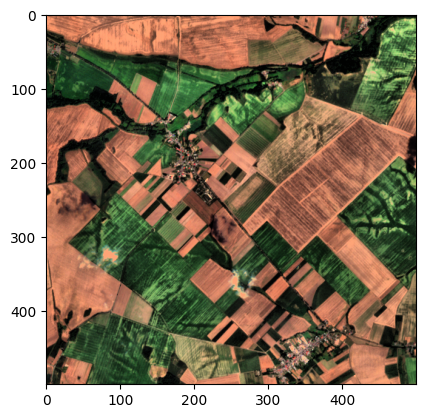

In [45]:
# Create RGB from ds_time_stack for one date

# select a month as an integer to select a date from (eg. 5 is May, 8 is August etc.)
# WARNING: needs to be a month between start_date and stop_date
month_selected = 8
# Select if you want the RGB image to get more sharpe or not
image_equalization = False

if month_selected in list_of_months:
  # take first image of the month selected
  xdate = ds_time_stack.sel(time=ds_time_stack.time.dt.month.isin([month_selected])).time[0]
  rgb_da = clip_nan_ufunc(xr.concat([ds_time_stack.red.sel(time=xdate),
                                   ds_time_stack.green.sel(time=xdate),
                                   ds_time_stack.blue.sel(time=xdate)], dim='band'), percentile=1)
else:
  import random
  date_index = random.randint(0,len(ds_time_stack.time)-1) # choose one random date only
  rgb_da = clip_nan_ufunc(xr.concat([ds_time_stack.red.isel(time=date_index),
                                    ds_time_stack.green.isel(time=date_index),
                                    ds_time_stack.blue.isel(time=date_index)], dim='band'), percentile=1)

rgb_da = rgb_da.assign_coords(band=['r','g','b'])

### Transpose to (y, x, band) 
rgb_da = rgb_da.transpose('y', 'x', 'band')
print(rgb_da.shape)
print(rgb_da)

# Visualization
if image_equalization:
  # allow for better contrast
  rgb_da_image = exposure.equalize_adapthist(rgb_da.values,clip_limit=0.01)
else:
  rgb_da_image = rgb_da
plt.imshow(rgb_da_image)
#plt.axis('off')
#plt.savefig("rgb_test.png", bbox_inches='tight', pad_inches = 0)

In [46]:
# Convert xarray to numpy and check the form
if isinstance(rgb_da_image, np.ndarray):
  rgb_da_numpy = rgb_da_image
else:
  rgb_da_numpy = rgb_da_image.to_numpy()

print(type(rgb_da_numpy))
print(rgb_da_numpy.shape)

<class 'numpy.ndarray'>
(500, 500, 3)


Need now to be converted to 0 to 255 for saving it as RGB:

In [47]:
# Is there nan values?
if np.isnan(np.sum(rgb_da_numpy)):
  new_rgb_da_numpy = np.nan_to_num(rgb_da_numpy) #remove NaN values
  #np.isnan(np.sum(new_rgb_da_numpy))
else:
  new_rgb_da_numpy = rgb_da_numpy

In [48]:
# Normalizing in the range 0 to 1.
rgb_da_numpy_norm = (new_rgb_da_numpy-np.min(new_rgb_da_numpy))/(np.max(new_rgb_da_numpy)-np.min(new_rgb_da_numpy))

#print(rgb_da_numpy_norm)

# Scaling from 0 to 255 for future images pixel values
rgb_da_numpy_norm*=255

#print(rgb_da_numpy_norm)

# convert to uint8 for image pixel value
rgb_da_numpy_converted = rgb_da_numpy_norm.astype(np.uint8)

print(type(rgb_da_numpy_converted))
print(rgb_da_numpy_converted.shape)
image = rgb_da_numpy_converted

<class 'numpy.ndarray'>
(500, 500, 3)


In [53]:
# Export the numpy array to a png
from PIL import Image as im

data = im.fromarray(rgb_da_numpy_converted)
path_file = '/content/drive/MyDrive/omdena-poland/data/rgb_da_numpy_converted.png'

if path.exists(path_file):
  data.save('/content/drive/MyDrive/omdena-poland/data/rgb_da_numpy_converted.png')
else:
  print(path_file, "already exists.")

In [50]:
%%script echo skipping
# Visualization
import cv2
plt.figure()
plt.imshow(image)
plt.axis('off')
plt.show()

skipping


In [51]:
%%script echo skipping
# Read back the image
import cv2
image = cv2.imread('/content/drive/MyDrive/omdena-poland/data/'+image_RGB_file_name)
image = cv2.imread('/content/drive/MyDrive/omdena-poland/data/rgb_da_numpy_converted.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(type(image))
print(image.shape)

skipping


Checked: kept dimensions (500, 500, 3). Good to go to the segmentation notebook or cells below.

In [85]:
# issue with geopandas on this notebook - ran code in aoi.ipynb notebook and saved that file to get LUCAS points
LUCAS_points_in_subset = pd.read_csv('/content/drive/MyDrive/omdena-poland/task-1-dataset/LUCAS_points_in_subset_32633_dataframe.csv', index_col=0)
LUCAS_points_in_subset

POINT_ID        LAT        LON            COUNTY              STATE  \
2052  48843034  50.145247  17.893165  Głubczyce County  Opole Voivodeship   
3047  48843032  50.127385  17.890194  Głubczyce County  Opole Voivodeship   
3389  48883034  50.141369  17.948848  Głubczyce County  Opole Voivodeship   

               LC1  index_right  FID      LON_32633     LAT_32633  
2052       unknown            0    0  706703.703726  5.558788e+06  
3047  Common wheat            0    0  706568.382196  5.556794e+06  
3389    Sugar beet            0    0  710698.423362  5.558513e+06

In [55]:
def matrix_corner_coordinates(rio_da):
        # x,y-origin of the matrix top-left corner of the 2D epsg:32633 coordinates matrix
        x00 = rio_da.x.values[0]
        y00 = rio_da.y.values[0]
        # x, y of the matrix bottom-right corner of the 2D epsg:32633 coordinates matrix
        xlast = rio_da.x.values[-1]
        ylast = rio_da.y.values[-1]
        return x00,y00,xlast,ylast

In [136]:
# We know that this LUCAS point is in the middle but we can imagine that
# we have several LUCAS point in the tile subset, so
# for any LUCAS point we need to find the pixel coordinates
# this will be useful for the "segment-anything" output

x00,y00,xlast,ylast = matrix_corner_coordinates(rgb_da)
print("x00,y00,xlast,ylast",x00,y00,xlast,ylast)
# Point(14.77941841, 52.67745247) # (GPS_LONG (x), GPS_LAT (y))
# WARNING: LUCAS POINT needs to be in tile coordinate system
# WARNING: only true if the LUCAS points are in the dataframe, carefull!
#start_stop_pixel_pairs = []
x_pixel = []
y_pixel = []
for idx, row in LUCAS_points_in_subset.iterrows():
  x_start = row['LON_32633'] #row['LON'] #p_tile.geometry.centroid.x.values[0] # lat 50.141369 	long 17.948848 	,
  print("x_start",x_start)
  y_start = row['LAT_32633'] #p_tile.geometry.centroid.y.values[0], max_opole.loc[[3548]]['LAT'].values[0]
  print("y_start",y_start)
  floor_diff_x = np.floor(abs(x_start - x00))
  floor_diff_y = np.floor(abs(y_start - y00))

  pixel_x_start = int(floor_diff_x // 10) # x start in pixel
  print("pixel_x_start",pixel_x_start)
  pixel_y_start = int(floor_diff_y // 10) # y start in pixel
  print("pixel_y_start",pixel_y_start)
  #pair_coor = tuple((pixel_x_start,pixel_y_start))
  #start_stop_pixel_pairs.append(pair_coor)

  x_pixel.append(pixel_x_start)
  y_pixel.append(pixel_y_start)

LUCAS_points_in_subset['x_pixel'] = x_pixel
LUCAS_points_in_subset['y_pixel'] = y_pixel

x00,y00,xlast,ylast 705905.0 5560775.0 710895.0 5555785.0
x_start 706703.7037255024
y_start 5558788.035508272
pixel_x_start 79
pixel_y_start 198
x_start 706568.382196173
y_start 5556794.181882332
pixel_x_start 66
pixel_y_start 398
x_start 710698.4233616532
y_start 5558512.752286263
pixel_x_start 479
pixel_y_start 226


# Part 3: "segment-anything" mask on an RGB image

Create a "segment-anything" mask on the RGB image and save it for future use.

Two methods:
1.   Run the cells below. If the 'cuda' is not available it will be a slow process.
2.   Open the "Shared_segment_seg.ipynb" notebook and run it. Due to a more
recent version of python it seems the 'cuda' is available.


### Setup and installation

In [ ]:
!nvcc --version

In [ ]:
!python --version

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    # sometimes GPU is not available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    #!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

### Running Segment-Anything

In [57]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [58]:
#image_RGB_file_name = "rgb_da_numpy_converted_"+ds_time_stack.tile_id+".png"
#image = cv2.imread('/content/drive/MyDrive/omdena-poland/data/'+image_RGB_file_name)
image = cv2.imread('/content/drive/MyDrive/omdena-poland/data/rgb_da_numpy_converted.png')
print(type(image))
print(image.shape)

<class 'numpy.ndarray'>
(500, 500, 3)


In [59]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

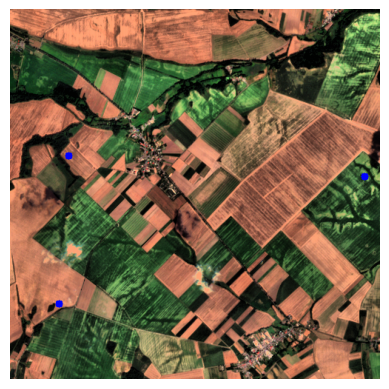

In [137]:
plt.figure()
image2 = image.copy()

#for pixel_x_start, pixel_y_start in start_stop_pixel_pairs:
#  print(pixel_x_start,pixel_y_start)
for idx, row in LUCAS_points_in_subset.iterrows():
  pixel_x_start = row['x_pixel']
  pixel_y_start = row['y_pixel'] 
  cv2.circle(image2, (int(pixel_x_start),int(pixel_y_start)), radius=5, color=(0, 0, 255), thickness=-1) # LUCAS point

plt.imshow(image2)
plt.axis('off')
plt.show()

In [ ]:
import sys
sys.path.append("")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = 'vit_h'
#device = 'cuda' #depending on availability (see cell which install pytorch)
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)
print(f"You are running on {device}. It will take a while!")

In [61]:
from os import path
path_file = '/content/drive/MyDrive/omdena-poland/data/masks.npy'

if path.exists(path_file):
  # load
  # image: rgb_da_numpy_converted.png was used for this mask
  # corresponding array: rgb_da_numpy_converted
  masks = np.load(path_file, allow_pickle=True)
else:
  # create
  # take a while on 'cpu'
  masks = mask_generator.generate(image)
  # Export output masks. 
  # WARNINGS: using pickle library, can create security issues.
  np.save('/content/drive/MyDrive/omdena-poland/data/masks.npy',masks)

In [63]:
# optional library for visualization
!pip install -q supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 11.9 MB/s eta 0:00:00


79 198
66 398
479 226


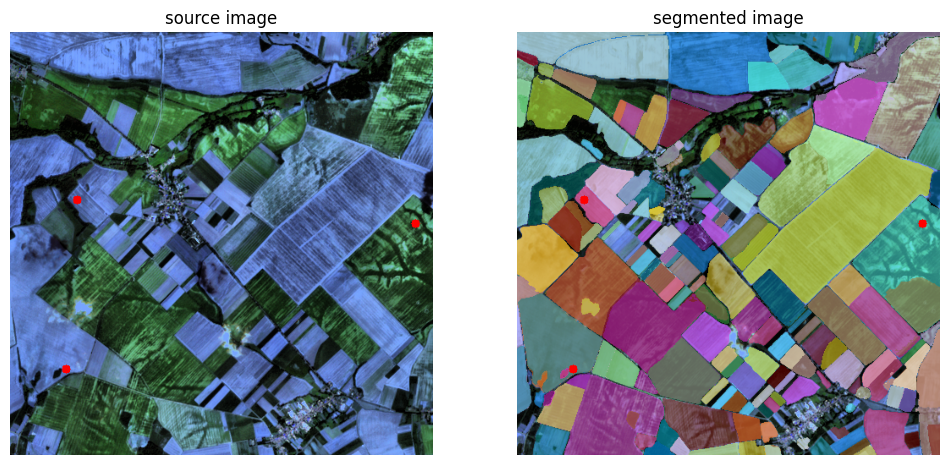

In [138]:
import supervision as sv
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=masks)

annotated_image = mask_annotator.annotate(scene=image2.copy(), detections=detections)

# Note: x axis →, y axis ↓ , origin top-left corner
for idx, row in LUCAS_points_in_subset.iterrows():
#for pixel_x_start, pixel_y_start in start_stop_pixel_pairs:
  pixel_x_start = row['x_pixel']
  pixel_y_start = row['y_pixel'] 
  print(pixel_x_start,pixel_y_start)
  cv2.circle(annotated_image, (int(pixel_x_start),int(pixel_y_start)), radius=5, color=(0, 0, 255), thickness=-1) # LUCAS point

sv.plot_images_grid(
    images=[image2, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

# Part 4: Load the masks and extract one unique mask shapefile

Reload the masks list as the raw output of "segment-anything":

In [65]:
if 'masks' in locals():
  print('masks already loaded')
else:
  # image: rgb_da_numpy_converted.png was used for this mask
  # corresponding array: rgb_da_numpy_converted
  masks = np.load('/content/drive/MyDrive/omdena-poland/data/masks.npy', allow_pickle=True)

masks already loaded


In [66]:
%%script echo skipping
# masks is a list of dictionnaries
# look at the key of a random individual dictionary 
print(masks[0].keys())

skipping


In [67]:
%%script echo skipping
# Create a list of all the mask (extract from dictionnaries) for visualization
masks_all = [
    mask['segmentation']
    for mask
    in sorted(masks, key=lambda x: x['area'], reverse=True) 
]

skipping


## Part 4a: Find exact mask for LUCAS points

Find the mask which corresponds to the LUCAS POINT. Take only the one with the highest stability and prediction scores.

In [139]:
field_queue = LUCAS_points_in_subset['POINT_ID'].values.tolist()
field_queue

[48843034, 48843032, 48883034]

In [140]:
LUCAS_points_in_subset

POINT_ID        LAT        LON            COUNTY              STATE  \
2052  48843034  50.145247  17.893165  Głubczyce County  Opole Voivodeship   
3047  48843032  50.127385  17.890194  Głubczyce County  Opole Voivodeship   
3389  48883034  50.141369  17.948848  Głubczyce County  Opole Voivodeship   

               LC1  index_right  FID      LON_32633     LAT_32633  x_pixel  \
2052       unknown            0    0  706703.703726  5.558788e+06       79   
3047  Common wheat            0    0  706568.382196  5.556794e+06       66   
3389    Sugar beet            0    0  710698.423362  5.558513e+06      479   

      y_pixel  
2052      198  
3047      398  
3389      226

In [145]:
masks_stability_all = [
    mask['segmentation']
    for mask
    in sorted(masks, key=lambda x: x['stability_score'], reverse=True)
]

lucas_field_masks = {}
field_queue = LUCAS_points_in_subset['POINT_ID'].values.tolist()
for i, boolean_mask in enumerate(masks_stability_all):
  if not field_queue: # if empty we got a mask for each points we can stop
    break
  for idx, row in LUCAS_points_in_subset.iterrows():
      pixel_x_start = row['x_pixel']
      pixel_y_start = row['y_pixel']
      point_id = row['POINT_ID']
      if boolean_mask[pixel_y_start, pixel_x_start] == True and point_id in field_queue: #row = x and column = y
        print(point_id)
        # From float to integer
        one_unique_mask_num = boolean_mask.astype(int) 
        # Convert into xarray to get the coordinates back from the original subset (rgb_da)
        one_unique_mask_img_da = xr.DataArray(one_unique_mask_num,
                                        dims=['y','x'],
                                        coords={'x':rgb_da.coords['x'],
                                                'y':rgb_da.coords['y']})
        one_unique_mask_img_da = one_unique_mask_img_da.chunk({'x': 'auto', 'y': 'auto'}).astype(int)
        lucas_field_masks[point_id] = one_unique_mask_img_da
        out_file_name = write_shapefile(one_unique_mask_img_da, ds_time_stack, one_unique_mask_img_da,point_id)
        field_queue.remove(point_id)

48883034
-------Writing to Shapefile-------
Output saved to: shp_dir/UYR_code_demo_clustering_x708406.8671437781_y5558268.745109705_step500_pointid48883034.shp
48843034
-------Writing to Shapefile-------
Output saved to: shp_dir/UYR_code_demo_clustering_x708406.8671437781_y5558268.745109705_step500_pointid48843034.shp
48843032
-------Writing to Shapefile-------
Output saved to: shp_dir/UYR_code_demo_clustering_x708406.8671437781_y5558268.745109705_step500_pointid48843032.shp


list mask segment sorted by stability score already loaded
79 198
[73, 114]


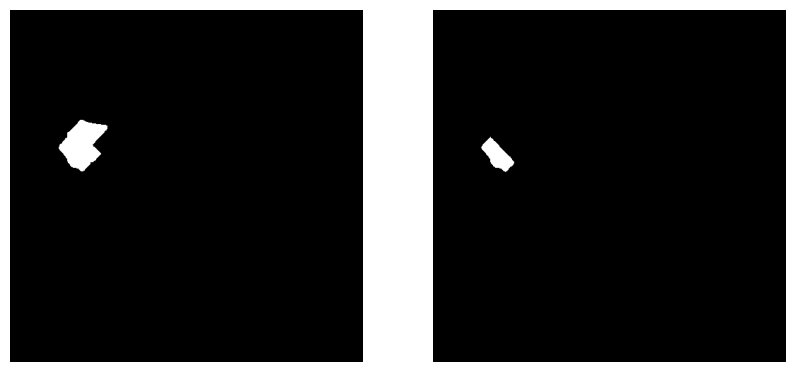

In [147]:
#Visualization for one field as demo
if 'masks_stability_all' in locals():
  print("list mask segment sorted by stability score already loaded")
else:
  masks_stability_all = [
      mask['segmentation']
      for mask
      in sorted(masks, key=lambda x: x['stability_score'], reverse=True)
  ]

idx_list = []
masks_sel = []
pixel_x_start = LUCAS_points_in_subset["x_pixel"].iloc[0]
pixel_y_start = LUCAS_points_in_subset["y_pixel"].iloc[0]
print(pixel_x_start,pixel_y_start)
for i, boolean_mask in enumerate(masks_stability_all):
  if boolean_mask[pixel_y_start, pixel_x_start] == True: #row = x and column = y
    idx_list.append(i)
    masks_sel.append(boolean_mask)
print(idx_list)

sv.plot_images_grid(
    images=masks_sel,
    grid_size=(1, 2),
    size=(10, 10)
)

In [148]:
%%script echo skipping
# Create shapefile for the field of the LUCAS point

# From float to integer
one_unique_mask_num = masks_sel[0].astype(int) 

# Convert into xarray to get the coordinates back from the original subset (rgb_da)
one_unique_mask_img_da = xr.DataArray(one_unique_mask_num,
                                dims=['y','x'],
                                coords={'x':rgb_da.coords['x'],
                                        'y':rgb_da.coords['y']})
one_unique_mask_img_da = one_unique_mask_img_da.chunk({'x': 'auto', 'y': 'auto'}).astype(int)

# Visualization 100% overlap free mask
# Segmented area in yellow
one_unique_mask_img_da.plot()

skipping


In [149]:
%%script echo skipping
#t0 = time.time()
### Write segments to shapefile
write_shapefile(one_unique_mask_img_da, ds_time_stack, one_unique_mask_img_da,point_id)
#print("Shapefile write done in %0.3fs." % (time.time() - t0))

skipping


### Create a dataframe for a mask region only

First, let's do some feature engineering with the bands for the full subset.

### NDWI - Masking out water

Now we can start to compute spectral index values that will help us differentiate crop pixels from non-crop pixels. We will start with water, by using the Normalized Difference Water Index. First, we will compute the mean NDWI for the full growing season for each pixel. Then, we will compute mean NDWI for just the peak growing season, when crop fields are not likely to be bare earth, which can have a high NDWI value. In this case, there is not a large difference, but we can spot a few areas better with the peak vegetation snapshot.

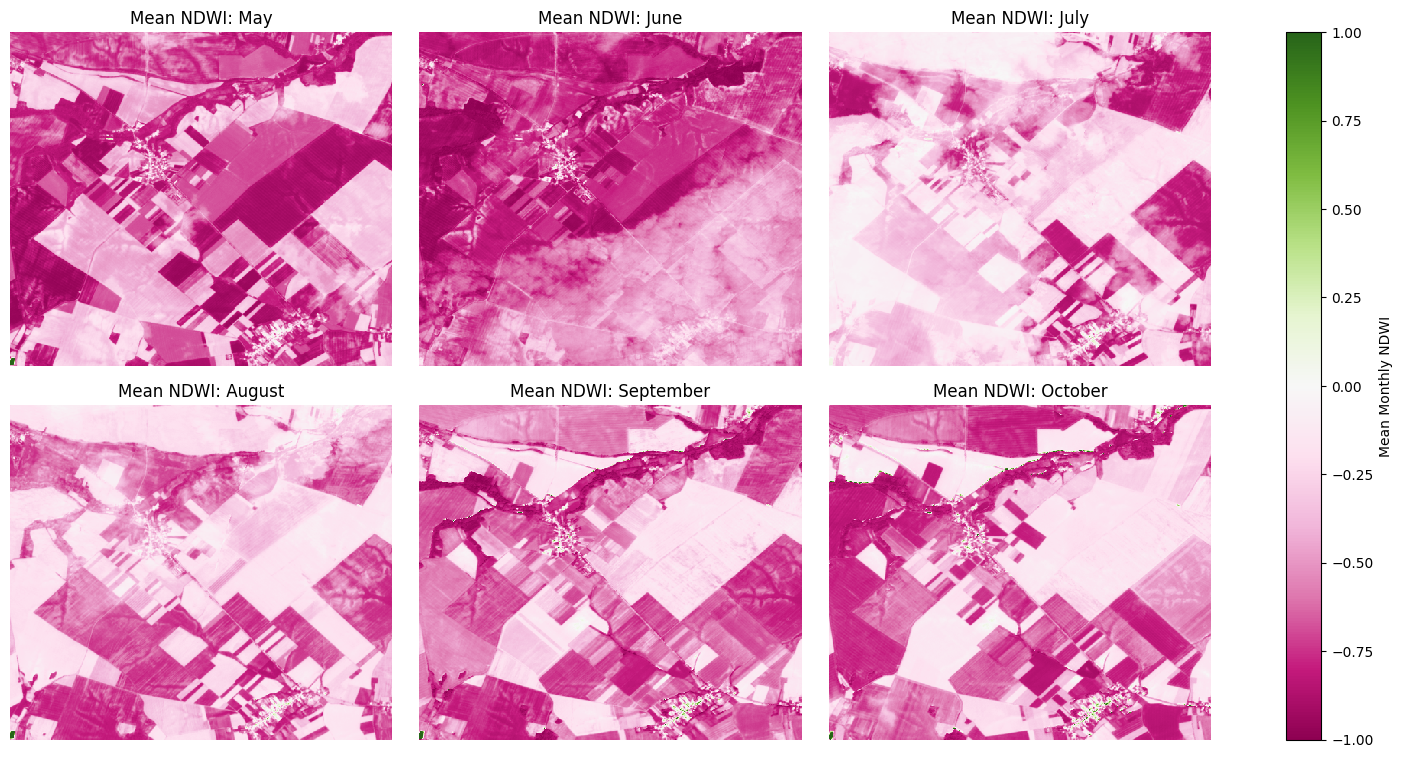

In [76]:
### NDWI stats: 
### NDWI mean per month
ndwi_mon_mean = ndwi_xr(ds_time_stack.resample(time='1MS').mean(dim='time', skipna = True))
ndwi_mon_mean.name = 'ndwi_mon_mean'

# Visualization - take time
g = ndwi_mon_mean.plot(figsize=(16,8), x='x', y='y', col='time', col_wrap=3, cmap='PiYG', cbar_kwargs={'label': 'Mean Monthly NDWI'})

for i, ax in enumerate(g.axes.flat):
    ax.set_title('Mean NDWI: ' + list_of_months_str[i])
    ax.axis('off')
    
plt.draw()

### NDVI Statistics: Identifying crop pixels

Next, we will look at monthly NDVI, Normalized Difference Vegetation Index. This is critical for capturing the temporal characteristics of crop fields, which will start the season with bare earth then have a spike in vegetation and then return to bare earth after being harvested. We can compute a few different NDVI statistics to look at how we can utilize those characteristics in our crop mapping model. 

First, we will look at statistics over the full growing season, then at monthly NDVI values. We can see that taking the mean NDVI for the full season is does not effectively differentiate crop pixels because they vary throughout the season. Standard Deviation and Variance show the temporal nature of the vegetation change better. Min, max and range are more sensitive to noisy, erroneous pixels because a single cloudy outlier pixel can skew the calculation. Temporal Standard Deviation seems to be more resistant to this kind of noise while effectively differentiating crop pixels from other land cover types. 

In [77]:
### NDVI stats: 
### Standard Deviation appears to be the most resistant to noise/clouds (compared to min, max, range, mean)
#ndvi_mean = ndvi_xr(ds_time_stack).mean(dim='time', skipna = True)
ndvi_mon_max = ndvi_xr(ds_time_stack.resample(time='1MS').max(dim='time', skipna = True))
#ndvi_max = ndvi_xr(ds_time_stack).max(dim='time', skipna = True)  # Influenced by clouds
ndvi_mon_min = ndvi_xr(ds_time_stack.resample(time='1MS').min(dim='time', skipna = True))
#ndvi_min = ndvi_xr(ds_time_stack).min(dim='time', skipna = True)  # Influenced by clouds
#ndvi_range = ndvi_max - ndvi_min                                  # Influenced by clouds, might be better with monthly mean
ndvi_mon_std = ndvi_xr(ds_time_stack.resample(time='1MS').std(dim='time', skipna = True))
#ndvi_std = ndvi_xr(ds_time_stack).std(dim='time', skipna = True)  # pretty resistant to cloud noise
#ndvi_var = ndvi_xr(ds_time_stack).var(dim='time', skipna = True)

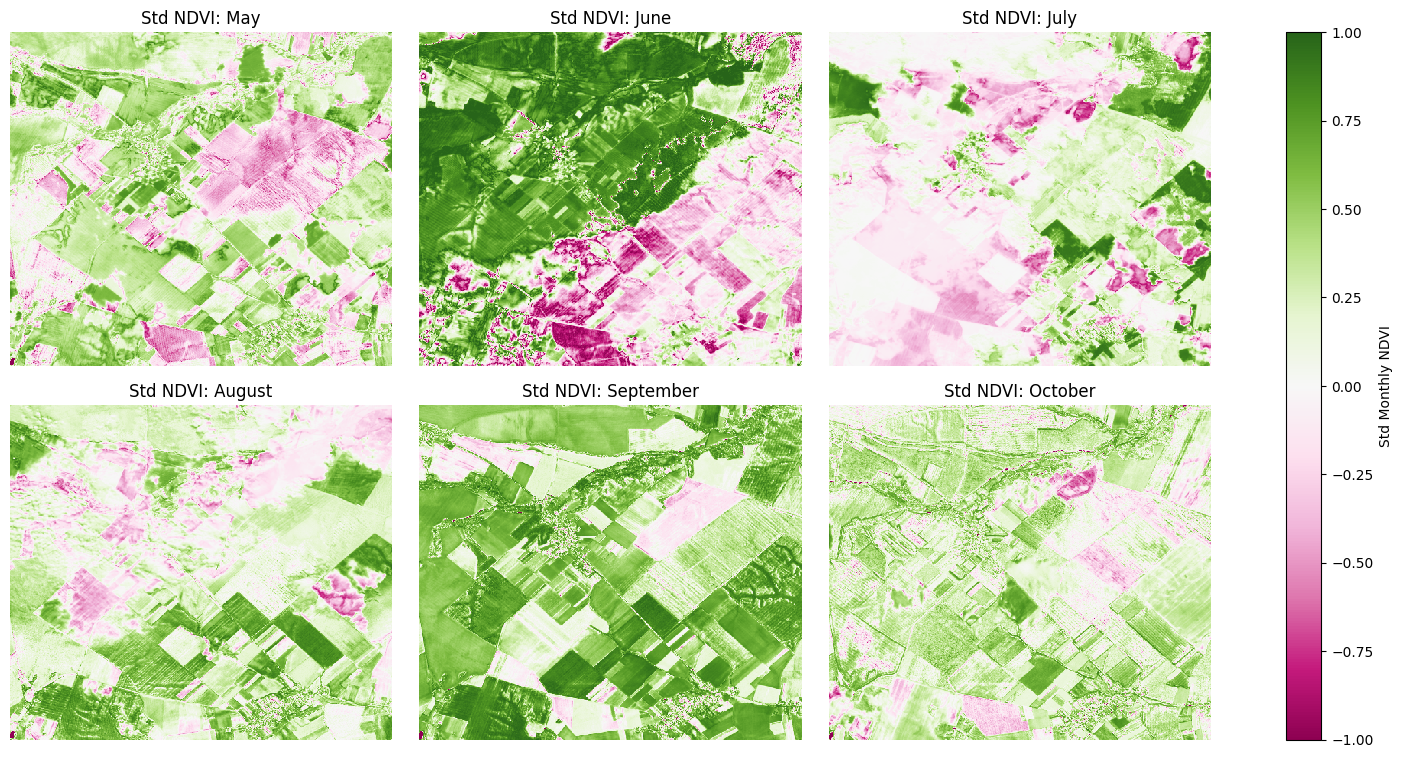

In [78]:
# Visualization - takes time
g = ndvi_mon_std.plot(figsize=(16,8), x='x', y='y', col='time', col_wrap=3, cmap='PiYG', cbar_kwargs={'label': 'Std Monthly NDVI'})

for i, ax in enumerate(g.axes.flat):
    ax.set_title('Std NDVI: ' + list_of_months_str[i])
    ax.axis('off')
    
plt.draw()

So, we can use median instead of mean to try to reduce the impact of the cloud mask in the image. Since there is not a parallel implementation of the median operation in dask, we have to coerce the data into numpy arrays to compute the median values serially, instead of in parallel like the other statistics computations. To accomplish this, we will define a new dataset from the red and NIR bands of the data and specify that we want the underlying values of the data. By passing the `.values` call to the bands in xarray it will return the underlying numpy arrays for the bands that we need to compute NDVI. We can then compute monthly median values for NDVI into a new layer. 

By visualizing the data (this time using some matplotlib functionality to clean up and label the outputs a little bit) we can see that the noise from the cloud masking process is mostly gone and we are left with a cleaner version of monthly NDVI values. This monthly median NDVI data will be used in our clustering step to group pixels with similar temporal vegetative curves together and from there we can classify each as crop or non-crop to create a binary crop mask.  

In [79]:
%%time
### START TIMING
t_start = time.perf_counter()
t_proc_start = time.process_time()

### Median - can't be computed with dask arrays, so it has to be converted to np arrays and the full stack loaded into memory and processed serially
ds_time_stack_no_dask = xr.Dataset({'red':(['time', 'y', 'x'],ds_time_stack.red.values),
                                    'nir':(['time', 'y', 'x'],ds_time_stack.nir.values)}, coords=ds_time_stack.coords)
### Compute monthly median and convert output to dask by passing chunk size method
ndvi_mon_med = ndvi_xr(ds_time_stack_no_dask.resample(time='1MS').median(dim='time', skipna = True, keep_attrs=True).sortby('time')).chunk({'x':'auto', 'y':'auto'})

### STOP TIMING
print("Monthly Median Total CPU time:", time.process_time() - t_proc_start)
print("Monthly Median Total Wall time:", time.perf_counter() - t_start)

Monthly Median Total CPU time: 27.77820422900004
Monthly Median Total Wall time: 34.25300028100037
CPU times: user 27.2 s, sys: 603 ms, total: 27.8 s
Wall time: 34.3 s


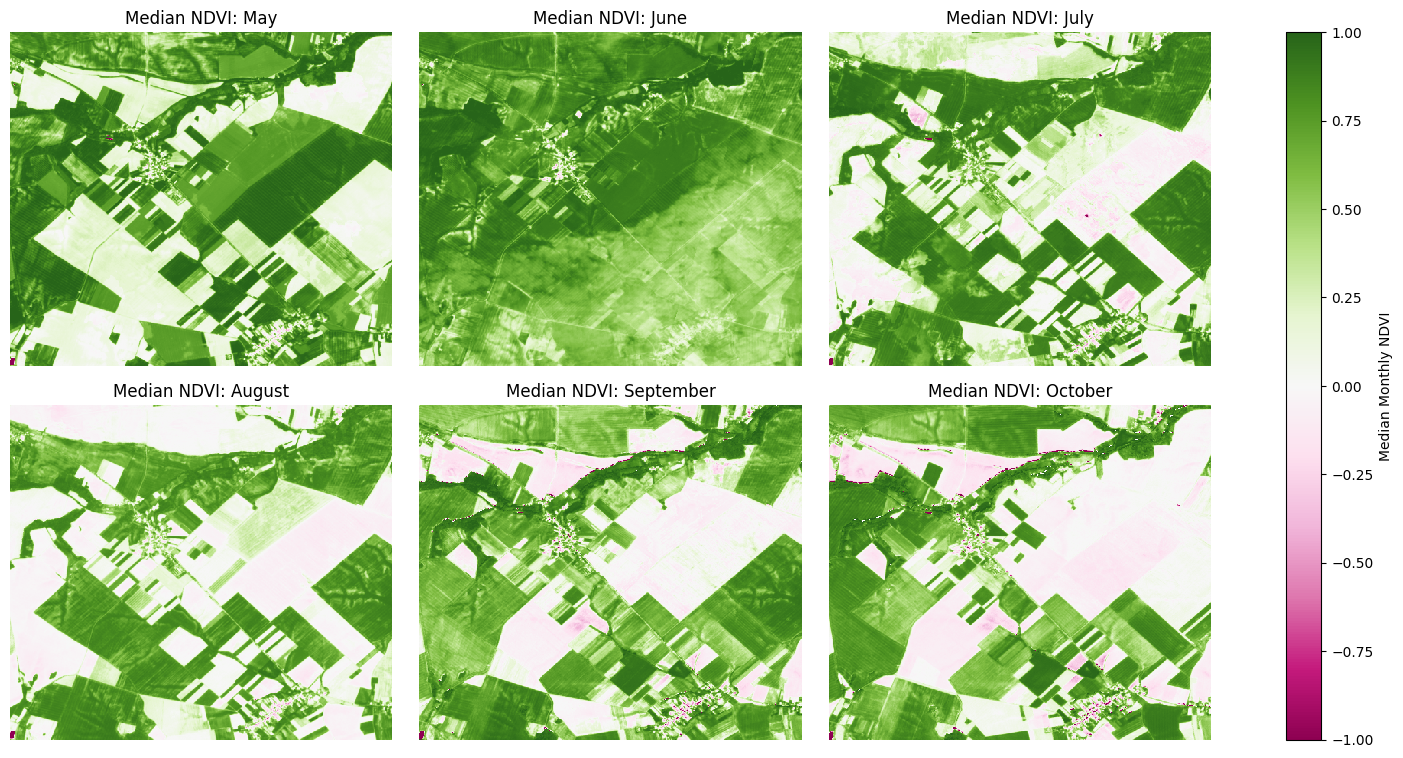

In [80]:
# Visualization - takes time
g = ndvi_mon_med.plot(figsize=(16,8), x='x', y='y', col='time', col_wrap=3, cmap='PiYG', cbar_kwargs={'label': 'Median Monthly NDVI'})

for i, ax in enumerate(g.axes.flat):
    ax.set_title('Median NDVI: ' + list_of_months_str[i])
    ax.axis('off')
    
plt.draw()

### Combine features and create data frame


In [81]:
### Combine into single dataset
preproc_ds = xr.Dataset({'ndwi_mon_mean':ndwi_mon_mean,
                         'ndvi_mon_std':ndvi_mon_std,
                         'ndvi_mon_min':ndvi_mon_min,
                         'ndvi_mon_max':ndvi_mon_max,
                         'ndvi_mon_med':ndvi_mon_med})

### Set compression in the encoding dictionary to pass to the to_netcdf() call
comp = dict(zlib=True, complevel=6)
encoding = {var: comp for var in preproc_ds.data_vars}

"""
### START TIMING
t_start = time.perf_counter()
t_proc_start = time.process_time()
out_dir = "/content/drive/MyDrive/omdena-poland/preproc/"
test_out_fp = out_dir + out_file_name + '.nc'
print("saving preprocessed tile to:", test_out_fp)
Path(out_dir).mkdir(exist_ok=True)
preproc_ds.to_netcdf(test_out_fp,engine="h5netcdf")
print("saving preprocessed tile to:", test_out_fp)
### STOP TIMING
print("Writing NetCDF file Total CPU time:", time.process_time() - t_proc_start)
print("Writing NetCDF file Total Wall time:", time.perf_counter() - t_start)
"""
preproc_ds

<xarray.Dataset>
Dimensions:        (time: 6, y: 500, x: 500)
Coordinates:
  * time           (time) datetime64[ns] 2018-05-01 2018-06-01 ... 2018-10-01
  * y              (y) float64 5.561e+06 5.561e+06 ... 5.556e+06 5.556e+06
  * x              (x) float64 7.059e+05 7.059e+05 ... 7.109e+05 7.109e+05
Data variables:
    ndwi_mon_mean  (time, y, x) float64 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    ndvi_mon_std   (time, y, x) float64 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    ndvi_mon_min   (time, y, x) float64 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    ndvi_mon_max   (time, y, x) float64 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    ndvi_mon_med   (time, y, x) float64 dask.array<chunksize=(6, 500, 500), meta=np.ndarray>

### Apply the mask and average pixels per field area

Loop over the each LUCAS field in the subset. This full process is not efficient, it is just a demo of concept.

In [ ]:
%%script echo skipping
new_ds = preproc_ds.where(one_unique_mask_img_da==1)
#np.isnan(new_ds.nir.values).all()
new_ds = new_ds.mean(dim=['y', 'x'])
new_sd_df = new_ds.to_dataframe()

skipping


In [151]:
all_dataframes = []
for point_id, one_unique_mask_img_da in lucas_field_masks.items():
  new_ds = preproc_ds.where(one_unique_mask_img_da==1)
  new_ds = new_ds.mean(dim=['y', 'x']) # one value per band
  new_sd_df = new_ds.to_dataframe() # this line takes a while, need to find something more efficient
  new_sd_df['POINT_ID'] = point_id
  new_sd_df['target'] = LUCAS_points_in_subset[LUCAS_points_in_subset["POINT_ID"] == point_id]['LC1'].values[0]
  all_dataframes.append(new_sd_df)

In [153]:
all_fields_in_subset = pd.concat(all_dataframes)

In [154]:
all_fields_in_subset.to_csv('/content/drive/MyDrive/omdena-poland/data/all_fields_in_subset.csv')

In [155]:
all_fields_in_subset

ndwi_mon_mean  ndvi_mon_std  ndvi_mon_min  ndvi_mon_max  \
time                                                                  
2018-05-01      -0.314969      0.243672      0.103108      0.206141   
2018-06-01      -0.454530     -0.181968      0.726512      0.361237   
2018-07-01      -0.743634      0.289437      0.832347      0.656730   
2018-08-01      -0.644306      0.193975      0.755378      0.522779   
2018-09-01      -0.731489      0.665039      0.837080      0.802488   
2018-10-01      -0.477178      0.243327      0.580408      0.355259   
2018-05-01      -0.797976     -0.140785      0.872001      0.639189   
2018-06-01      -0.734871      0.586972      0.759647      0.700709   
2018-07-01      -0.093242      0.000453     -0.558654     -0.006417   
2018-08-01      -0.172577      0.135315     -0.041960      0.083946   
2018-09-01      -0.536863      0.606991     -0.645260      0.462801   
2018-10-01      -0.715204      0.173827      0.744135      0.668837   
2018-05-01      -0.893926     -0.057297      0.938535      0.757513   
2018-06-01      -0.758501      0.341045      0.798888      0.671998   
2018-07-01      -0.064033      0.008784     -0.435832     -0.000480   
2018-08-01      -0.193643      0.197064     -0.053280     -0.002907   
2018-09-01      -0.534490      0.558790      0.142559      0.465493   
2018-10-01      -0.754763      0.202744      0.813031      0.735843   

            ndvi_mon_med  POINT_ID        target  
time                                              
2018-05-01      0.102998  48883034    Sugar beet  
2018-06-01      0.495701  48883034    Sugar beet  
2018-07-01      0.876172  48883034    Sugar beet  
2018-08-01      0.779561  48883034    Sugar beet  
2018-09-01      0.816599  48883034    Sugar beet  
2018-10-01      0.115290  48883034    Sugar beet  
2018-05-01      0.794216  48843034       unknown  
2018-06-01      0.723627  48843034       unknown  
2018-07-01      0.073217  48843034       unknown  
2018-08-01     -0.000056  48843034       unknown  
2018-09-01      0.581533  48843034       unknown  
2018-10-01      0.714465  48843034       unknown  
2018-05-01      0.910602  48843032  Common wheat  
2018-06-01      0.723442  48843032  Common wheat  
2018-07-01     -0.002096  48843032  Common wheat  
2018-08-01     -0.032708  48843032  Common wheat  
2018-09-01      0.545757  48843032  Common wheat  
2018-10-01      0.767285  48843032  Common wheat

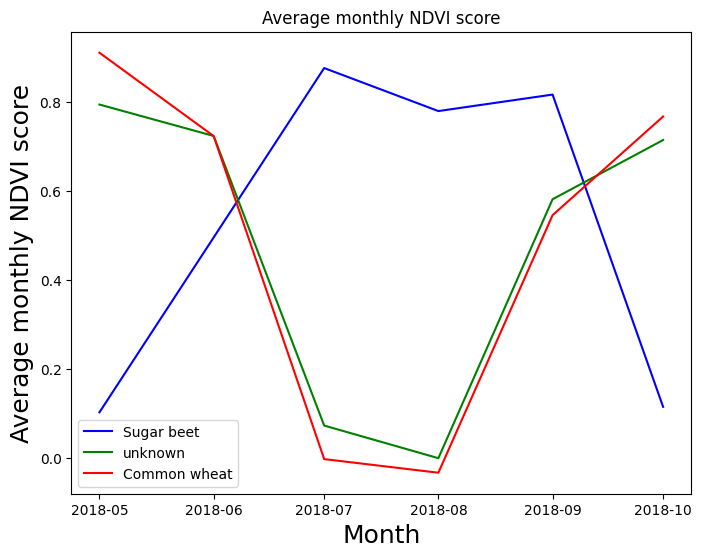

In [157]:
# Quick and dirty visualization
mdf2 = mdf.copy()
mdf2['time']= pd.to_datetime(mdf2['time'])
colors = ['red','green','blue']
fig, ax = plt.subplots(figsize=(8, 6))
for target in mdf2.target.unique():
  subdf = mdf2[mdf2["target"]==target]
  ax.plot(subdf.time, subdf.ndvi_mon_med, color = colors.pop(), label = target);
plt.xlabel('Month',fontsize=18)
plt.ylabel('Average monthly NDVI score',fontsize=18)
plt.title('Average monthly NDVI score')
plt.legend()
plt.show()

## Create format for future LSTM

In [162]:
# pivot the data
mdf = all_fields_in_subset.copy()
mdf.reset_index(inplace=True)
pivoted = mdf.pivot(index='target', columns='time')
# flatten the columns
pivoted.columns = [f'{col[0]}_{col[1].year}_{col[1].month}'  for col in pivoted.columns.values]
pivoted

ndwi_mon_mean_2018_5  ndwi_mon_mean_2018_6  \
target                                                     
Common wheat             -0.893926             -0.758501   
Sugar beet               -0.314969             -0.454530   
unknown                  -0.797976             -0.734871   

              ndwi_mon_mean_2018_7  ndwi_mon_mean_2018_8  \
target                                                     
Common wheat             -0.064033             -0.193643   
Sugar beet               -0.743634             -0.644306   
unknown                  -0.093242             -0.172577   

              ndwi_mon_mean_2018_9  ndwi_mon_mean_2018_10  \
target                                                      
Common wheat             -0.534490              -0.754763   
Sugar beet               -0.731489              -0.477178   
unknown                  -0.536863              -0.715204   

              ndvi_mon_std_2018_5  ndvi_mon_std_2018_6  ndvi_mon_std_2018_7  \
target                                                                        
Common wheat            -0.057297             0.341045             0.008784   
Sugar beet               0.243672            -0.181968             0.289437   
unknown                 -0.140785             0.586972             0.000453   

              ndvi_mon_std_2018_8  ...  ndvi_mon_med_2018_7  \
target                             ...                        
Common wheat             0.197064  ...            -0.002096   
Sugar beet               0.193975  ...             0.876172   
unknown                  0.135315  ...             0.073217   

              ndvi_mon_med_2018_8  ndvi_mon_med_2018_9  ndvi_mon_med_2018_10  \
target                                                                         
Common wheat            -0.032708             0.545757              0.767285   
Sugar beet               0.779561             0.816599              0.115290   
unknown                 -0.000056             0.581533              0.714465   

              POINT_ID_2018_5  POINT_ID_2018_6  POINT_ID_2018_7  \
target                                                            
Common wheat         48843032         48843032         48843032   
Sugar beet           48883034         48883034         48883034   
unknown              48843034         48843034         48843034   

              POINT_ID_2018_8  POINT_ID_2018_9  POINT_ID_2018_10  
target                                                            
Common wheat         48843032         48843032          48843032  
Sugar beet           48883034         48883034          48883034  
unknown              48843034         48843034          48843034  

[3 rows x 36 columns]

In [163]:
pivoted.to_csv('/content/drive/MyDrive/omdena-poland/data/all_fields_in_subset_lstm_ready.csv')

# NEXT WORK STEP SUGGESTION

* Create a stable work environnemnt
* Branch out of notebook
* Add cloud mask
* Use NDVI RGB image for segmentation instead of regular RGB (it may help in some cases)
* Add LUCAS points which are not not field for each subset. Aim to have the same amount of field and none-field in the subset to get a balanced dataset. Avoid using unknown LUCAS point, use known non-crop field. 
* Not using 10km grid anymore for selecting subset, but using directly clustering in a radius smaller than 2.5km (smaller than 5km diameter) tpo ensure the field are in the subset (suggestion:  https://stackoverflow.com/questions/53075481/how-do-i-cluster-a-list-of-geographic-points-by-distance#53094495  )
* Add more features using all the bands that Corpernicus has to offer. Some bands may have a 20m resolution instead of 10m so some resampling will be needed which should not be a problem.
* Make the code more efficient
* Create a data pipeline